# Job Search Model

(http://quant-econ.net/py/lake_model.html より)

## 個人の意思決定

次のような簡易モデルを考える．

* 失業中の労働者には賃金 $w$ の仕事のオファーが降ってくる．
* $w$ は $\{w_1, \ldots, w_n\}$ 上の何らかの確率分布にしたがう．
* オファー $w$ を受け入れれば，その賃金で働く．
  毎期 $\alpha$ の確率で離職し失業状態に戻る．
* オファーを拒否すれば，失業状態のまま．
  失業手当 $c$ を受け取る．
* 労働者は効用の現在価値の流列の和
  $$
  \sum_{t=0}^{\infty} \beta^t u(y_t)
  $$
  を最大化するように「受け入れ」または「拒否」の行動を決めていく．
  ただし，
  
  * $u$ は効用関数
  * $y_t$ は就労中なら賃金 $w$，失業中なら失業手当 $c$
  * $\beta$ は割引因子
  
  である．

これは最適停止問題の一種．
トレードオフは：

* オファーを拒否すると失業手当しかもらえない．
* いったん受け入れると外生的な理由 (確率 $\alpha$) でしか離職できない．
  将来もっと高い賃金が降ってくるかもしれないが，それを受け入れるオプションを失う．

状態 (state) は

* 賃金 $w_1$ で雇用中
* $\cdots$
* 賃金 $w_n$ で雇用中
* 失業中に賃金 $w_1$ のオファーが降ってきた
* $\cdots$
* 失業中に賃金 $w_n$ のオファーが降ってきた
* 離職したばかりで失業中 (失業手当 $c$ を得る)

であるだが，実は「賃金 $w_s$ で雇用中」という状態と
「失業中に賃金 $w_s$ のオファーが降ってきた」という状態は同一視してよい (両者の価値は等しい)．

政策 (policy) (精確には定常 Markov 政策) とは，
各状態に対して「受け入れ」「拒否」のいずれの行動をとるかを定めた関数のこと
(この定常 Markov 政策の範囲で考えれば十分)．
(失業中は「受け入れ」も「拒否」も選べないが，便宜上，どちらかを選べるがいずれの帰結も同じ，とする．)

けっきょく，Bellman 方程式は
$$
\begin{aligned}
V_s &= \max\{u(c) + \beta E[V_{s'}], u(w_s) + \beta[(1 - \alpha) V_s + \alpha U]\}
   \quad (s = 1, \ldots, n) \\
U   &= u(c) + \beta E[V_{s'}]
\end{aligned}
$$
と書ける．

* 最適政策関数 (optimal policy function) は

  * $w_s \geq w^*$ ならば受け入れ，$w_s < w^*$ ならば拒否

  という形になる．
* 最適政策関数が求まれば雇用状態・失業状態の遷移確率がわかり，その定常分布 $\pi$ も求まる．

実はこのクラスの問題は解析的に解けるが，ここでは QuantEcon.jl の `DiscreteDP` を使って解いてみる．

以下は
[ddp_ex_job_search_jl.ipynb](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/ddp_ex_job_search_jl.ipynb)
の簡易版．

In [1]:
using QuantEcon
import QuantEcon: solve
using Distributions
using PyPlot
using Roots

In [2]:
type JobSearchModel
    # Parameters
    w::Vector{Float64}
    w_pdf::Vector{Float64}
    beta::Float64
    alpha::Float64
    # Internal variables
    u::Function
    ddp::DiscreteDP
    num_states::Integer
    num_actions::Integer
    rej::Integer
    acc::Integer
    
    function JobSearchModel(w::Vector, w_pdf::Vector, beta::Float64, alpha::Float64)
        rho = 2
        # Utility function
        function u(y::Vector)
            small_number = -9999999
            nonpositive = (y .<= 0)
            if rho == 1
                util = log(y)
            else
                util = (y.^(1 - rho) - 1)/(1 - rho)
            end
            util[nonpositive] = small_number
            return util
        end
        u_w = u(w)
        
        num_states = length(w) + 1
        num_actions = 2
        rej, acc = 1, 2
        
        # Reward array
        R0 = zeros(num_states, num_actions)
        R0[1:end-1, acc] = u_w
        
        # Transition probability array
        Q = zeros(num_states, num_actions, num_states)
        # Reject
        for s in 1:num_states
            Q[s, rej, 1:end-1] = w_pdf
        end
        # Accept
        for s in 1:num_states-1
            Q[s, acc, s] = 1 - alpha
            Q[s, acc, end] = alpha
        end
        Q[end, acc, 1:end-1] = w_pdf
        
        ddp = DiscreteDP(R0, Q, beta)
        
        js = new(w, w_pdf, beta, alpha, u, ddp,
                 num_states, num_actions, rej, acc)
        return js
    end
end;

In [3]:
function solve(js::JobSearchModel, c::Float64)
    n, m = js.num_states, js.num_actions
    rej = js.rej
    js.ddp.R[:, rej] = js.u([c])[1]
    js.ddp.R[end, :] = js.u([c])[1]
    
    res = solve(js.ddp, PFI)
    V = res.v[1:end-1]  # Values of jobs
    U = res.v[end]  # Value of unemployed
    C = ind2sub(js.ddp, res.sigma)[1:end-1] - 1
    
    lamb = dot(js.w_pdf, C)
    pi = [js.alpha, lamb]
    pi /= sum(pi)
    
    return V, U, C, pi
end;

以下のパラメータ値は
[lakemodel_example.py](https://github.com/QuantEcon/QuantEcon.applications/blob/master/lake_model/lakemodel_example.py)
より．

In [4]:
w = linspace(0, 175, 201)
logw_dist = Normal(log(20), 1)
logw_dist_cdf = cdf(logw_dist, log(w))
logw_dist_pdf = logw_dist_cdf[2:end] - logw_dist_cdf[1:end-1]
logw_dist_pdf /= sum(logw_dist_pdf)
w = Array((w[2:end] + w[1:end-1])/2);

In [5]:
alpha = 0.013
alpha_q = (1-(1-alpha)^3)
beta = 0.99;

`JobSearchModel` タイプのインスタンスを作る：

In [6]:
js = JobSearchModel(w, logw_dist_pdf, beta, alpha_q);

例えば失業手当を $c = 40$ として解いてみる：

In [7]:
c = 40.
V, U, C, pi = solve(js, c);

In [8]:
s_star = length(w) - sum(C) + 1
println("Optimal policy: Accept if and only if w >= $(w[s_star])")

Optimal policy: Accept if and only if w >= 65.1875


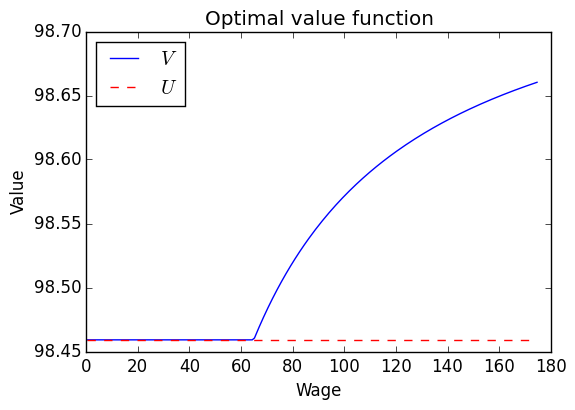

In [9]:
fig, ax = subplots(figsize=(6, 4))
ax[:plot](w, V, label=L"$V$")
ax[:plot]((w[1], w[end]), (U, U), "r--", label=L"$U$")
ax[:set_title]("Optimal value function")
ax[:set_xlabel]("Wage")
ax[:set_ylabel]("Value")
legend(loc=2)
show()

$c = 80$ とすると：

In [10]:
c = 80.
V, U, C, pi = solve(js, c)
s_star = length(w) - sum(C) + 1
println("Optimal policy: Accept if and only if w >= $(w[s_star])")

Optimal policy: Accept if and only if w >= 95.8125


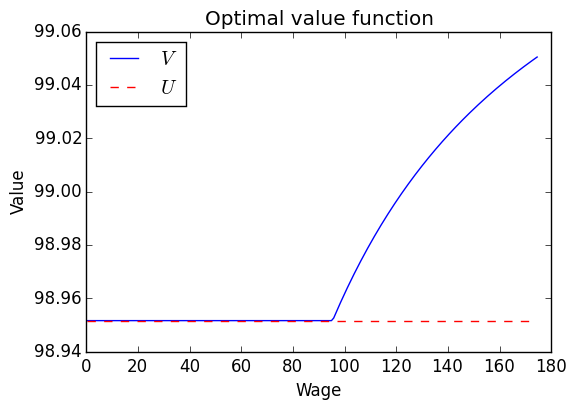

In [11]:
fig, ax = subplots(figsize=(6, 4))
ax[:plot](w, V, label=L"$V$")
ax[:plot]((w[1], w[end]), (U, U), "r--", label=L"$U$")
ax[:set_title]("Optimal value function")
ax[:set_xlabel]("Wage")
ax[:set_ylabel]("Value")
legend(loc=2)
show()

## 最適失業保険政策

次に，上の意思決定問題に直面している労働者が多数いるとして，
最適失業保険制度の設計問題を考える．

* 失業者に $c$ だけの失業手当を支払う．
  その財源として各人 (雇用者，失業者ともに) から税金 $T$ を徴収する．
  よって，税引き後の賃金は $w - T$，失業手当は $c - T$．
* $c$ と $T$ を決めると，それを所与として上記のように各人は最適行動をとり，
  失業状態・雇用状態上の定常分布 $\pi$ が求まる．
* 全体の人口の $\pi_1$ の割合の人が失業中，$\pi_2$ の割合の人が雇用中と考える．
  したがって，失業手当の支払総額は $\pi_1 c$．
  一方，税収は $T$．
* 空から価値は降ってこないので $T = \pi_1 c$ が成り立ってないといけない．
* この下で，社会全体の厚生を価値の期待値 (総和と解釈)
  $\pi_1 E[U|\text{失業状態}] + \pi_2 E[V|\text{雇用状態}]$
  で測る．
* $c$ をいろいろ変えて，社会構成を最大化するような値を求める．

トレードオフ：

* $c$ が増えると，リスクが減り，また高い賃金に出会えるまでより待てるようになる．
* $c$ が大きすぎると，失業者が増え，税負担が増える．

In [12]:
type UnemploymentInsurancePolicy
    w::Vector{Float64}
    w_pdf::Vector{Float64}
    beta::Float64
    alpha::Float64
end;

In [13]:
function solve_job_search_model(uip::UnemploymentInsurancePolicy,
                                c::Float64, T::Float64)
    js = JobSearchModel(uip.w-T, uip.w_pdf, uip.beta, uip.alpha)
    V, U, C, pi = solve(js, c-T)
    return V, U, C, pi
end;

In [14]:
function budget_balance(uip::UnemploymentInsurancePolicy, c::Float64, T::Float64)
    V, U, C, pi = solve_job_search_model(uip, c, T)
    return T - pi[1]*c
end;

In [15]:
function implement(uip::UnemploymentInsurancePolicy, c::Float64)
    # Budget balancing tax given c
    T = fzero(T -> budget_balance(uip, c, T), 0., c, xtolrel=1e-3)
    
    V, U, C, pi = solve_job_search_model(uip, c, T)
    
    EV = dot(C .* V, uip.w_pdf) / (dot(C, uip.w_pdf))
    W = pi[1] * U + pi[2] * EV
    
    return T, W, pi
end;

In [16]:
uip = UnemploymentInsurancePolicy(w, logw_dist_pdf, beta, alpha_q);

In [17]:
grid_size = 26
cvec = linspace(5, 135, grid_size)
Ts, Ws = Array(Float64, grid_size), Array(Float64, grid_size)
pis = Array(Float64, 2, grid_size)

for (i, c) in enumerate(cvec)
    T, W, pi = implement(uip, c)
    Ts[i], Ws[i], pis[:, i] = T, W, pi
end
i_max = indmax(Ws)
println("Optimal unemployment benefit: $(cvec[i_max])")

Optimal unemployment benefit: 67.4


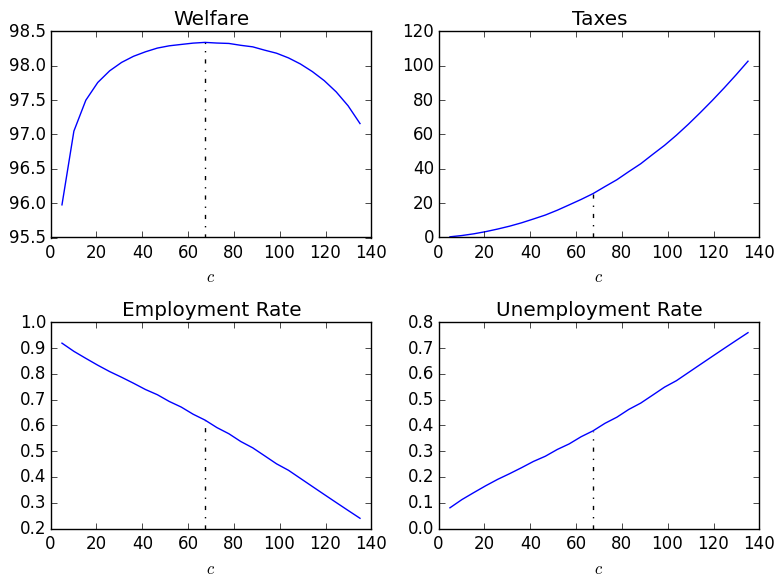

In [18]:
function plot(ax, y_vec, title)
    ax[:plot](cvec, y_vec)
    ax[:set_xlabel](L"$c$")
    ax[:vlines](cvec[i_max], ax[:get_ylim]()[1], y_vec[i_max], "k", "-.")
    ax[:set_title](title)
end

fig, axes = subplots(2, 2)
plot(axes[1, 1], Ws, "Welfare")
plot(axes[1, 2], Ts, "Taxes")
plot(axes[2, 1], vec(pis[2, :]), "Employment Rate")
plot(axes[2, 2], vec(pis[1, :]), "Unemployment Rate")

tight_layout()
show()

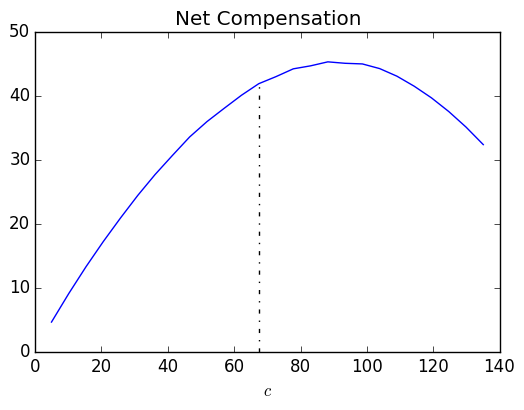

In [19]:
fig, ax = subplots(figsize=(6, 4))
plot(ax, cvec-Ts, "Net Compensation")
show()